In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [4]:
data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
213,214,0,2,"Givard, Mr. Hans Kristensen",male,30.0,0,0,250646,13.0000,NaN,S
503,504,0,3,"Laitinen, Miss. Kristina Sofia",female,37.0,0,0,4135,9.5875,NaN,S
136,137,1,1,"Newsom, Miss. Helen Monypeny",female,19.0,0,2,11752,26.2833,D47,S


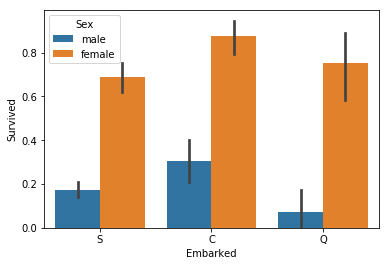

In [5]:
sns.barplot(x="Embarked", y="Survived", hue ="Sex", data=data_train);

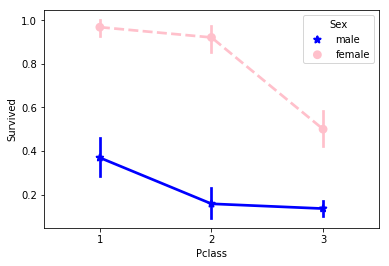

In [6]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

In [7]:
# here we "simplify" colums, so fill Nan values
# we grp people using age and siplify
def simplify_ages(df):
    # Fill NA/NaN values using -0.5
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    grp_names = ['Unknown',
                 'Baby',
                 'Child',
                 'Teenager',
                 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels = grp_names)
    df.Age = categories
    return df
# simplify cabins column
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df
# simplify fare column
def simplify_fare(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    grp_names = ['Unknown', '1_quartile', '2_quartile',
                   '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels = grp_names)
    df.Fare = categories
    return df
# simplify name column
def simplify_name(df):
    df['LastName'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df
# drop "no info" features
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)


In [8]:
# all methods to transform data
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fare(df)
    df = simplify_name(df)
    df = drop_features(df)
    return df

In [9]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)

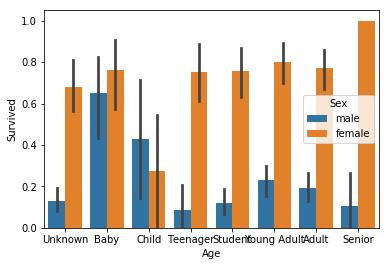

In [10]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

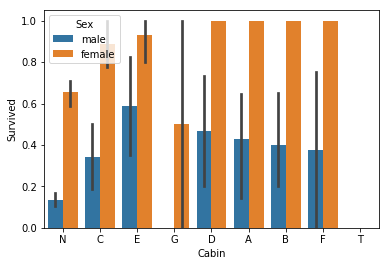

In [11]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

In [12]:
from sklearn import preprocessing
# convert each unique string value into a number
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'LastName', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,LastName,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [13]:
# separete "X" for "Y"
from sklearn.model_selection import train_test_split
x_all = data_train.drop(['Survived', 'PassengerId'], axis =1)
y_all = data_train['Survived']
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all,
                                                    test_size=num_test,
                                                    random_state=23)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }
# metric to compare
acc_scorer = make_scorer(accuracy_score)
# run grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
# set the clf to the best combination of parameters
clf = grid_obj.best_estimator_
# fit best algorithm
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.7932960893854749


TypeError: Singleton array array(981) cannot be considered a valid collection.